**This notebook is not to be taken as financial advice. I am not a qualified professional, so this notebook is only meant to be used for educational/entertainment purposes. Investing/trading can lead to losses.**

In [23]:
import numpy as np
import pandas as pd
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import display

from typing import List, Tuple
from functools import cache  # Python 3.9 required

import yfinance as yf

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 9

In [4]:
TREASURY_BILL_RATE = 4.09  #%, 2yr Feb 3rd, 2023
TRADING_DAYS_PER_YEAR = 250

In [28]:
# Needed for type hinting
class Asset:
  pass


def get_log_period_returns(price_history: pd.DataFrame):
  close = price_history['Close'].values  
  return np.log(close[1:] / close[:-1]).reshape(-1, 1)


# daily_price_history has to at least have a column, called 'Close'
class Asset:
  def __init__(self, name: str, daily_price_history: pd.DataFrame):
    self.name = name
    self.daily_returns = get_log_period_returns(daily_price_history)
    self.expected_daily_return = np.mean(self.daily_returns)
  
  @property
  def expected_return(self):
    return TRADING_DAYS_PER_YEAR * self.expected_daily_return

  def __repr__(self):
    return f'<Asset name={self.name}, expected return={self.expected_return}>'

  @staticmethod
  @cache
  def covariance_matrix(assets: Tuple[Asset]):  # tuple for hashing in the cache
    product_expectation = np.zeros((len(assets), len(assets)))
    for i in range(len(assets)):
      for j in range(len(assets)):
        if i == j:
          product_expectation[i][j] = np.mean(assets[i].daily_returns * assets[j].daily_returns)
        else:
          product_expectation[i][j] = np.mean(assets[i].daily_returns @ assets[j].daily_returns.T)
    
    product_expectation *= (TRADING_DAYS_PER_YEAR - 1) ** 2

    expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
    product_of_expectations = expected_returns @ expected_returns.T

    return product_expectation - product_of_expectations


def random_weights(weight_count):
    weights = np.random.random((weight_count, 1))
    weights /= np.sum(weights)
    return weights.reshape(-1, 1)


class Portfolio:
  def __init__(self, assets: Tuple[Asset]):
    self.assets = assets
    self.asset_expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
    self.covariance_matrix = Asset.covariance_matrix(assets)
    self.weights = random_weights(len(assets))
    
  def unsafe_optimize_with_risk_tolerance(self, risk_tolerance: float):
    res = minimize(
      lambda w: self._variance(w) - risk_tolerance * self._expected_return(w),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
      ],
      bounds=[(0., 1.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)
  
  def optimize_with_risk_tolerance(self, risk_tolerance: float):
    assert risk_tolerance >= 0.
    return self.unsafe_optimize_with_risk_tolerance(risk_tolerance)
  
  def optimize_with_expected_return(self, expected_portfolio_return: float):
    res = minimize(
      lambda w: self._variance(w),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
        {'type': 'eq', 'fun': lambda w: self._expected_return(w) - expected_portfolio_return},
      ],
      bounds=[(0., 1.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)

  def optimize_sharpe_ratio(self):
    # Maximize Sharpe ratio = minimize minus Sharpe ratio
    res = minimize(
      lambda w: -(self._expected_return(w) - TREASURY_BILL_RATE / 100) / np.sqrt(self._variance(w)),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
      ],
      bounds=[(0., 1.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)

  def _expected_return(self, w):
    return (self.asset_expected_returns.T @ w.reshape(-1, 1))[0][0]
  
  def _variance(self, w):
    return (w.reshape(-1, 1).T @ self.covariance_matrix @ w.reshape(-1, 1))[0][0]

  @property
  def expected_return(self):
    return self._expected_return(self.weights)
  
  @property
  def variance(self):
    return self._variance(self.weights)

  def __repr__(self):
    return f'<Portfolio assets={[asset.name for asset in self.assets]}, expected return={self.expected_return}, variance={self.variance}>'

In [29]:
def yf_retrieve_data(tickers: List[str]):
  dataframes = []

  for ticker_name in tickers:
    ticker = yf.Ticker(ticker_name)
    history = ticker.history(period='10y')

    if history.isnull().any(axis=1).iloc[0]:  # the first row can have NaNs
      history = history.iloc[1:]
  
    assert not history.isnull().any(axis=None), f'history has NaNs in {ticker_name}'
    dataframes.append(history)
  
  return dataframes

## Usage example

In [30]:
stocks = ['ABNB', 'DKS', 'GOOGL', 'GS', 'HLI', 'LOW', 'LULU', 'LVLU', 'MAR', 'MS', 'NVDA', 'RF','SNOW','UNTY','SCHA'
         , 'SCHF','SCHH','SCHX','VHT','VIG']

daily_dataframes = yf_retrieve_data(stocks)
assets = tuple([Asset(name, daily_df) for name, daily_df in zip(stocks, daily_dataframes)])

In [32]:
assets

(<Asset name=ABNB, expected return=-0.1915227240836323>,
 <Asset name=DKS, expected return=0.2579370027021528>,
 <Asset name=GOOGL, expected return=0.20935580306324356>,
 <Asset name=GS, expected return=0.17094486420508773>,
 <Asset name=HLI, expected return=0.32788732715823316>,
 <Asset name=LOW, expected return=0.3384883420043093>,
 <Asset name=LULU, expected return=0.21617209304776913>,
 <Asset name=LVLU, expected return=0.0>,
 <Asset name=MAR, expected return=0.20888104584789144>,
 <Asset name=MS, expected return=0.22381605719556563>,
 <Asset name=NVDA, expected return=0.5050276276171826>,
 <Asset name=RF, expected return=0.24061040626507063>,
 <Asset name=SNOW, expected return=0.20880996854694395>,
 <Asset name=UNTY, expected return=0.0>,
 <Asset name=SCHA, expected return=0.2788621133110084>,
 <Asset name=SCHF, expected return=0.15544668137761325>,
 <Asset name=SCHH, expected return=0.22358211736773465>,
 <Asset name=SCHX, expected return=0.1681649763157675>,
 <Asset name=VHT, ex

C:\Users\ALadd\AppData\Local\Temp\ipykernel_24768\3387679904.py:58: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(
C:\Users\ALadd\AppData\Local\Temp\ipykernel_24768\3387679904.py:75: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(
C:\Users\ALadd\AppData\Local\Temp\ipykernel_24768\3387679904.py:90: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(


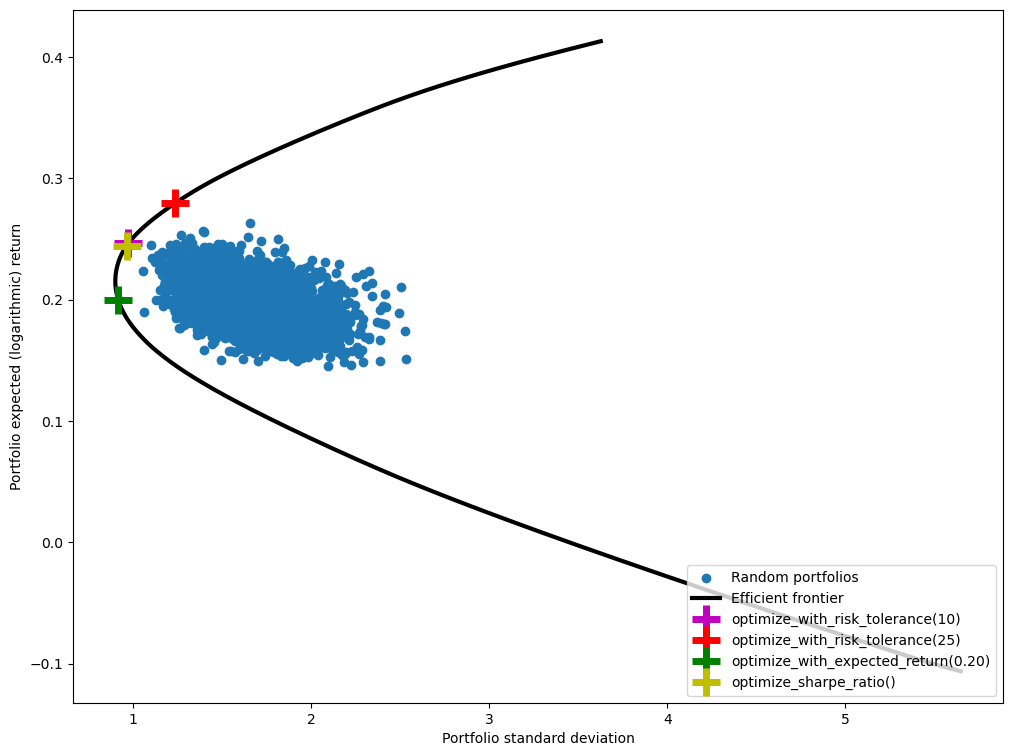

In [33]:
X = []
y = []

# Drawing random portfolios
for i in range(3000):
  portfolio = Portfolio(assets)
  X.append(np.sqrt(portfolio.variance))
  y.append(portfolio.expected_return)

plt.scatter(X, y, label='Random portfolios')

# Drawing the efficient frontier
X = []
y = []
for rt in np.linspace(-300, 200, 1000):
  portfolio.unsafe_optimize_with_risk_tolerance(rt)
  X.append(np.sqrt(portfolio.variance))
  y.append(portfolio.expected_return)

plt.plot(X, y, 'k', linewidth=3, label='Efficient frontier')

# Drawing optimized portfolios
portfolio.optimize_with_risk_tolerance(10)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'm+', markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(10)')

portfolio.optimize_with_risk_tolerance(25)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'r+', markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(25)')

portfolio.optimize_with_expected_return(0.20)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'g+', markeredgewidth=5, markersize=20, label='optimize_with_expected_return(0.20)')

portfolio.optimize_sharpe_ratio()
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'y+', markeredgewidth=5, markersize=20, label='optimize_sharpe_ratio()')

plt.xlabel('Portfolio standard deviation')
plt.ylabel('Portfolio expected (logarithmic) return')
plt.legend(loc='lower right')
plt.show()

In [34]:
pd.options.display.float_format = "{:,.5f}".format

In [35]:
portfolio = Portfolio(assets)
portfolio.optimize_with_risk_tolerance(0)
riskless_weights = portfolio.weights.flatten()

portfolio.optimize_with_risk_tolerance(20)
weights_risk_tolerance = portfolio.weights.flatten()

portfolio.optimize_with_expected_return(0.25)
weights_return = portfolio.weights.flatten()

portfolio.optimize_sharpe_ratio()
weights_sharpe = portfolio.weights.flatten()

display(
  pd.DataFrame(
    list(
      zip(
        [asset.name for asset in portfolio.assets],
        riskless_weights,
        weights_risk_tolerance,
        weights_return,
        weights_sharpe,
      )
    ),
    columns=[
      'asset',
      'optimize_with_risk_tolerance(10)',
      'optimize_with_risk_tolerance(25)',
      'optimize_with_expected_return(0.20)',
      'optimize_sharpe_ratio()',
    ],
  )
)

C:\Users\ALadd\AppData\Local\Temp\ipykernel_24768\3387679904.py:58: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(
C:\Users\ALadd\AppData\Local\Temp\ipykernel_24768\3387679904.py:75: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(
C:\Users\ALadd\AppData\Local\Temp\ipykernel_24768\3387679904.py:90: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(


,asset,optimize_with_risk_tolerance(10),optimize_with_risk_tolerance(25),optimize_with_expected_return(0.20),optimize_sharpe_ratio()
0,ABNB,0.00971,0.00000,0.00000,0.00000
1,DKS,0.01939,0.02782,0.02460,0.02360
2,GOOGL,0.04633,0.03980,0.04318,0.04423
3,GS,0.04334,0.01735,0.02882,0.03227
4,HLI,0.04595,0.10331,0.08004,0.07303
5,LOW,0.04251,0.10050,0.07689,0.06981
6,LULU,0.02133,0.02009,0.02092,0.02115
7,LVLU,0.00381,0.00000,0.00000,0.00004
8,MAR,0.03351,0.02862,0.03112,0.03180
9,MS,0.03549,0.03665,0.03669,0.03657
